In [1]:
# Libraries Import
import matplotlib.pyplot as plt
import numpy as np
from dolfin import *
import os

In [2]:
# Helping self defined Functions
# Read subdomains from .msh file
def readDomains(inPath,inFile):
    # Read .msh File
    fid = open(inPath+inFile+'.msh', 'r')
    # Initialize variables
    found = 0
    finished = 0
    physicalNames = {}
    # Loop througn .msh lines
    for line in fid:
        if '$EndPhysicalNames' in line:
            finished == 1
            break
        elif '$PhysicalNames' in line:
            found = 1
        elif found==1 and finished == 0:
            word=line.split()
            if len(word)==3:
                physicalNames[word[2][1:len(word[2])-1]] = int(word[1])

    return physicalNames

# Convert .msh file to .xml files
def msh2xml(inPath,inFile,outPath,outFile):
    cmd = 'dolfin-convert '+inPath+inFile+'.msh '+outPath+outFile+'.xml'
    print(cmd)
    os.system(cmd)

# Deformation Tensor
def DD(u):
    #Cartesian
    D = 0.5*(nabla_grad(u) + nabla_grad(u).T)
    return D
#     return 0.5*(nabla_grad(u) + nabla_grad(u).T)

# Stress Tensor
def TT(u, p, mu):
    #Cartesian
    T = 2*mu*DD(u) - p*Identity(len(u))
    return T

In [3]:
# Inputs
# Mesh File
meshPath = './meshFiles/'
meshFile = 'ParallelPlates' 

# Timestep
dt = 0.1

# Pressure Difference
Pin = 0.1
Pout = 0

# Fluid Properties
rho = 1000
mu = 0.1
alpha = 0.9
# Mesh Elements
# Velocity
velocityElementfamily = 'Lagrange'
velocityElementOrder = 2
# Pressure
pressureElementfamily = 'Lagrange'
pressureElementOrder = 1
msh2xml(meshPath,meshFile,meshPath,meshFile)

# Solver Parameters
absTol = 1e-8
relTol = 1e-9
maxIter = 15
linearSolver = 'mumps'

dolfin-convert ./meshFiles/ParallelPlates.msh ./meshFiles/ParallelPlates.xml


{'Inlet': 1, 'Outlet': 2, 'BottomWall': 3, 'TopWall': 4, 'Fluid': 5}


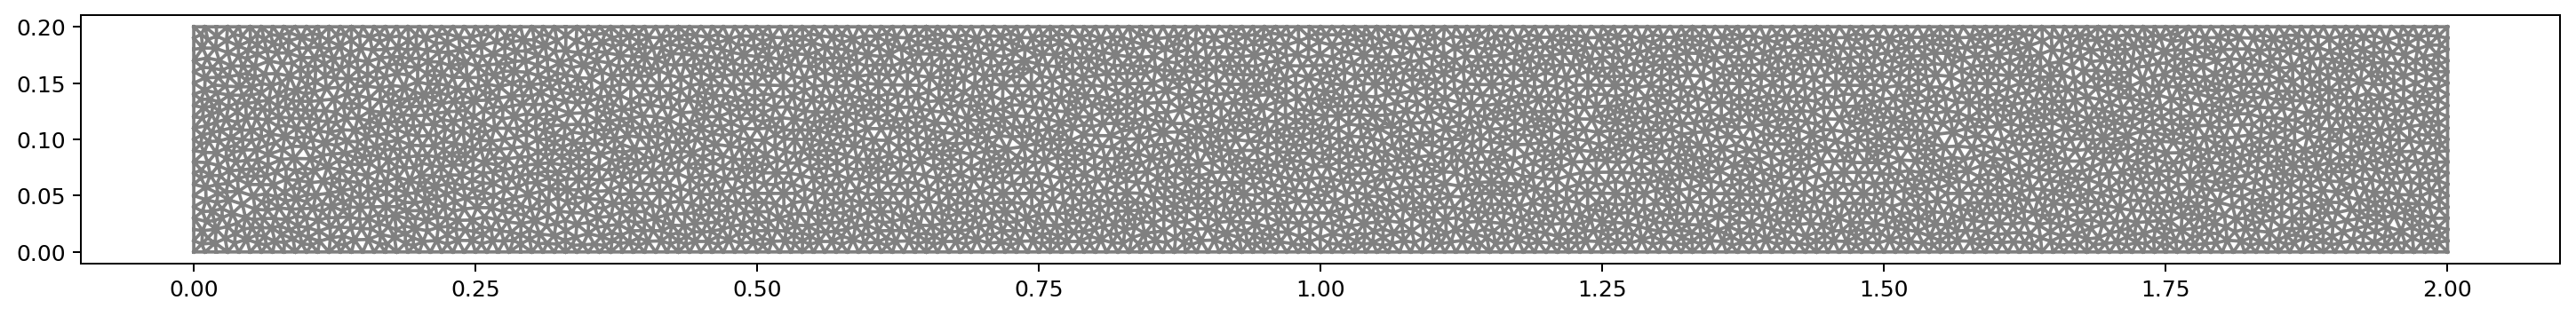

In [4]:
# Mesh Reading
# Load Subdomains
Subdomains = readDomains(meshPath,meshFile)
print(Subdomains)

# Option 2 - Gmsh generation and XML Conversion
meshObj = Mesh(meshPath+meshFile +'.xml')
# Initialize boundaries (inlet, outlet, etc...)
boundaries = MeshFunction('size_t',meshObj,meshPath+meshFile + "_facet_region.xml")
# Initialize subdomain (fluid)
markers = MeshFunction('size_t',meshObj,meshPath+meshFile + '_physical_region.xml')
# Open new figure
plt.figure(figsize=(20, 10), dpi=180, facecolor='w', edgecolor='k')
# plot Mesh and save image
plot(meshObj)
plt.savefig('Mesh.png')

In [5]:
# Get Element Shape: Triangle, etc...
elementShape = meshObj.ufl_cell()

# Set Mesh Elements
Uel = VectorElement(velocityElementfamily, elementShape, velocityElementOrder) # Velocity vector field
Pel = FiniteElement(pressureElementfamily, elementShape, pressureElementOrder) # Pressure field
UPel = MixedElement([Uel,Pel])

In [6]:
# Define any measure associated with domain and subdomains
dx = Measure('dx', domain=meshObj)
ds = Measure('ds', domain=meshObj, subdomain_data=boundaries)

# Vectors Normal to the Mesh
n = FacetNormal(meshObj) # Normal vector to mesh

In [7]:
# Function Spaces: Flow
# Mixed Function Space: Pressure and Velocity
W = FunctionSpace(meshObj,UPel)

w0 = Function(W)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [8]:
 ##### Functions
## Trial and Test function(s)
dw = TrialFunction(W)
(v, q) = TestFunctions(W)
w = Function(W)

# Split into Velocity and Pressure
(u, p) = (as_vector((w[0], w[1])), w[2])
(U, P) = W.split()

# Time step Constant
Dt = Constant(dt)

In [9]:

# Bilinear Form
# Linear Momentum Conservation: F = a - L
          # Inertia Term                    # Viscous Forces Term           
a1 = (rho*dot(dot(u,grad(u) ) ,v) + inner(TT(u,p,mu),DD(v)))*dx() 

        # Inlet Pressure                         # Outlet Pressure                            # Gravity
L1 = - (Pin)*dot(n,v)*ds(Subdomains['Inlet']) - (Pout)*dot(n,v)*ds(Subdomains['Outlet']) # + inner(rho*fb(inputs),v)*dx()

# Mass Conservation(Continuity)
a2 = (q*div(u))*dx()
L2 = 0
# Complete Weak Form
F = (a1 + a2) - (L1 + L2)
# Jacobian Matrix
J = derivative(F,w,dw)

# Apply Flow Boundary Conditions
bcU1 = DirichletBC(W.sub(0),Constant((0.0,0.0)),boundaries,Subdomains['BottomWall'])
bcU2 = DirichletBC(W.sub(0),Constant((0.0,0.0)),boundaries,Subdomains['TopWall'])
bcU = [bcU1,bcU2]


##########   Numerical Solver Properties
# Problem and Solver definitions
problemU = NonlinearVariationalProblem(F,w,bcU,J)
solverU = NonlinearVariationalSolver(problemU)
# # Solver Parameters
prmU = solverU.parameters
# #info(prmU,True)  #get full info on the parameters
prmU['nonlinear_solver'] = 'newton'
# prmU['newton_solver']['absolute_tolerance'] = absTol
# prmU['newton_solver']['relative_tolerance'] = relTol
# prmU['newton_solver']['maximum_iterations'] = maxIter
prmU['newton_solver']['linear_solver'] = linearSolver

# Solve Problem
(no_iterations,converged) = solverU.solve()

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


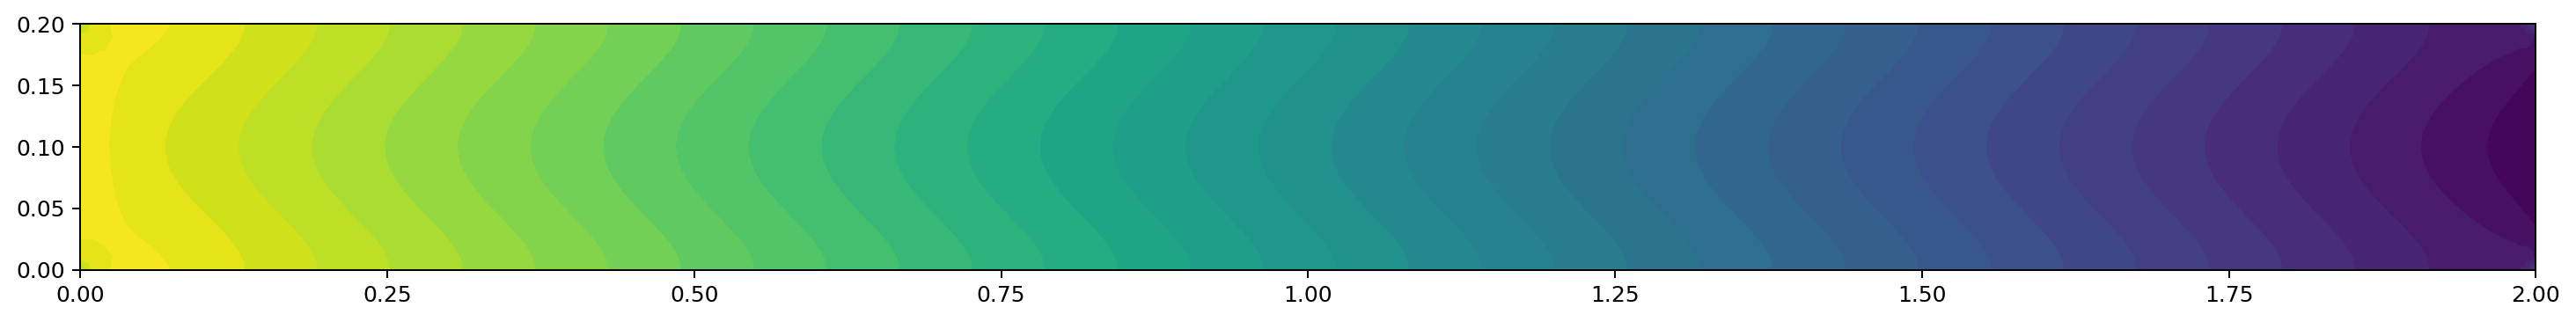

In [10]:
# Open new figure
plt.figure(figsize=(20, 10), dpi=180, facecolor='w', edgecolor='k')
plot(p)


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


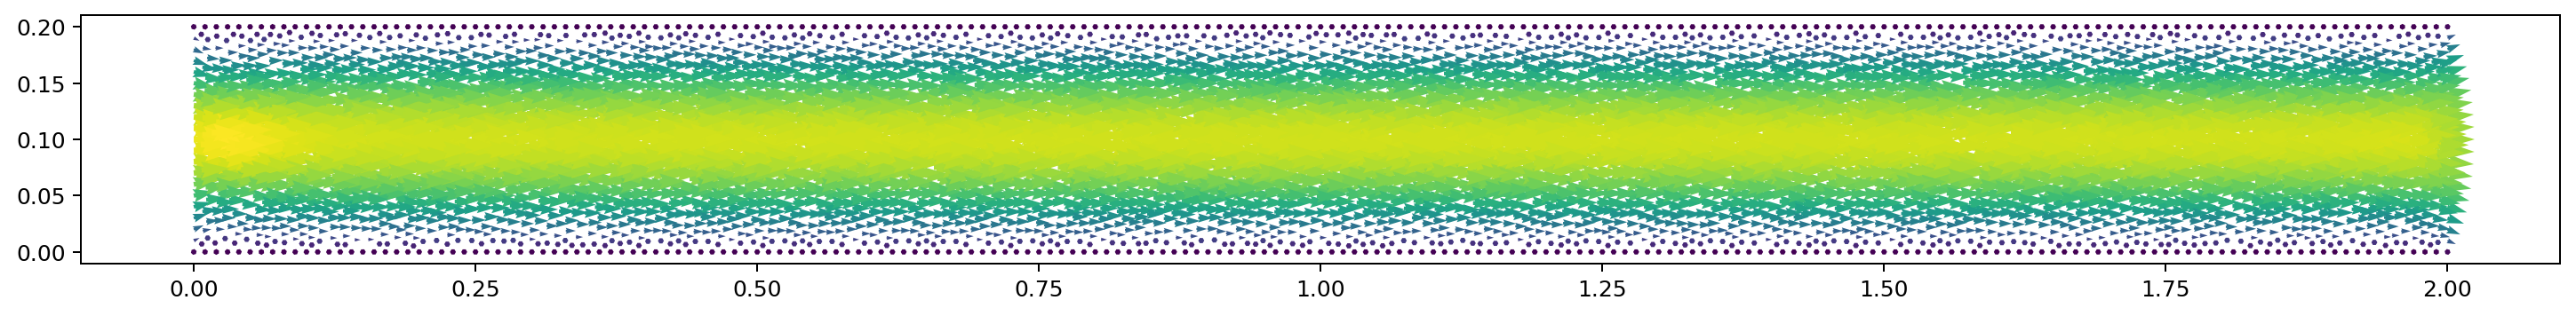

In [11]:
# Open new figure
plt.figure(figsize=(20, 10), dpi=180, facecolor='w', edgecolor='k')
plot(u)
